In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
from scipy.interpolate import interp2d

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

{'path': '/home/katrin/Documents', 'path_crab': '/home/katrin/Documents/Crab'}
spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : TnUS02X0 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralM

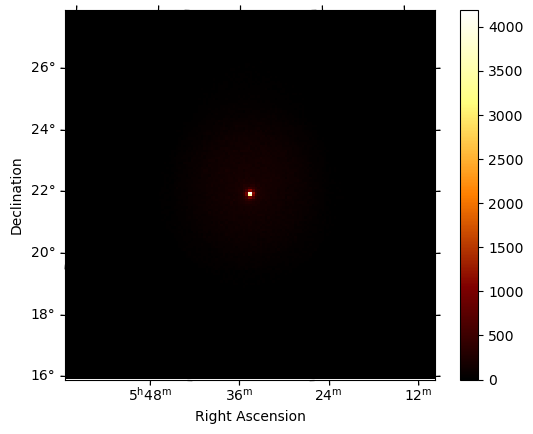

In [3]:
import json
with open("config.json") as json_data_file:
    config = json.load(json_data_file)
config = config['local']
print(config)
source = 'Crab'
path = config["path"]
path_crab = config["path_crab"]


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

In [4]:


def compute_fraction(Ls_new, x_new,
               y_new, threshold, plot = False):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    outside = Ls_new* (Ls_new < offset)
    inside = Ls_new* (Ls_new >= offset)
    fraction_inside = np.sum(inside)/ tot_int
    fraction=  (tot_int - np.sum(outside))/ tot_int 
    if plot:
        fig,ax = plt.subplots(1,1, )
        im =ax.pcolormesh(x_new,
               y_new,
               Ls_new)
        fig.colorbar(im);
        ax.set_title(f"frac inside : {fraction_inside * 100:.4} %")

        CS = ax.contour(x_new,
               y_new,Ls_new, colors=('gold',), levels = [Ls_new.min() + threshold])    
    return fraction_inside

def plot_L(Ls_new, x_new, y_new, threshold, find_min = True, color = 'red'):
    index_min, index_max,  ampli_min,  ampli_max, index_best, ampli_best = compute_errors(
        Ls_new, x_new, y_new, threshold, find_min = find_min )
    fig,ax = plt.subplots(1,1, )
    im =ax.pcolormesh(x_new,
       y_new,
       Ls_new)
    fig.colorbar(im);

    CS = ax.contour(x_new,
       y_new,Ls_new, colors=('gold',), levels = [ Ls_new.min() + threshold]) 
    linewidth = 2
    ax.hlines(y = index_min, xmin = x_new[0], xmax = x_new[-1], color = color,
             linestyle = 'dotted', linewidth = linewidth)
    ax.hlines(y = index_max, xmin = x_new[0], xmax = x_new[-1], color = color,
             linestyle = 'dotted', linewidth = linewidth)

    ax.vlines(x = ampli_min, ymin = y_new[0], ymax = y_new[-1], color = color,
             linestyle = 'dotted', linewidth = linewidth)
    ax.vlines(x = ampli_max, ymin = y_new[0], ymax = y_new[-1], color = color,
             linestyle = 'dotted', linewidth = linewidth)

    ax.plot(ampli_best, index_best, 'x')

    plt.ylabel("amplitude")
    plt.xlabel("index")
    return CS
    
    
def compute_errors(Ls_new, x_new,
               y_new, threshold , find_min = False):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    outside = Ls_new* (Ls_new < offset)
    inside = Ls_new* (Ls_new >= offset)
    if find_min: # find min:
        pos = np.where(inside >= 0 )
        ampli_best = x_new[np.where(Ls_new == Ls_new.min())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.min())[0][0]]
        
    else:  # find max
        pos = np.where(inside > 0 )
        ampli_best = x_new[np.where(Ls_new == Ls_new.max())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.max())[0][0]]
        
    delta_bin = (x_new[1] - x_new[0] )/2
    ampli_min = x_new[np.min(pos[1])]-delta_bin
    ampli_max = x_new[np.max(pos[1])]+delta_bin
    ampli_best += delta_bin
    
    delta_bin = (y_new[1] - y_new[0] )/2
    index_min = y_new[np.min(pos[0])]-delta_bin
    index_max = y_new[np.max(pos[0])]+delta_bin
    index_best += delta_bin
    
    print(ampli_best, index_best)
    return index_min, index_max,  ampli_min,  ampli_max, index_best, ampli_best
    

## Varying the Exposure

In [6]:
savefig = False
biass = [0.0]
sigmass = [0.5]
sigma_assumed = 1

In [10]:
def create_dataset(b, s):
    sys_d_cor = sys_dataset(dataset_asimov= dataset_standard,
                        shift = 0,
                        tilt = 0,
                        bias = 0, 
                        sigma = s,
                        rnd = False)
    dataset_asimov = sys_d_cor.create_dataset()
    dataset_asimov_N = sys_d_cor.create_dataset_N()
    dataset_asimov_N.models.parameters['norm_nuisance'].frozen  = True
    dataset_asimov_N.models.parameters['tilt_nuisance'].frozen  = True
    dataset_asimov_N.models.parameters['bias'].frozen  = True
    #dataset_asimov_N.models.parameters['resolution'].frozen  = True
    #dataset_asimov_N.models.parameters['resolution'].value  = s
    

    zero = 1e-12
    penalising_invcovmatrix = np.zeros((4, 4))
    if b ==0 :
        b_ = zero
    else:
        b_ = b
    np.fill_diagonal(penalising_invcovmatrix, [1/zero**2, 1/zero**2, 1/b_**2, 1/s**2])
    dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix
    return dataset_asimov, dataset_asimov_N


for b in biass:
    for s in sigmass:
        dataset_asimov, dataset_asimov_N = create_dataset(b,s )
        


evaluate: 0.5 0.0
evaluate: 0.5 0.0


corr
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.536e+05                 │              Nfcn = 196              │
│ EDM = 1.02e-05 (Goal: 2e-06)     │            time = 2.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬────────

evaluate: 0.0031171804074744294 0.0
evaluate: 0.0031171804074744294 0.0
evaluate: 0.0031171804074744294 0.0
evaluate: 0.0031171804074744294 0.0
evaluate: 0.0031171804074744294 0.0
evaluate: 0.0031171804074744294 0.0
evaluate: 0.0031171804074744294 0.0
evaluate: 0.0031171804074744294 0.0
evaluate: 0.0031171804074744294 0.0
evaluate: 0.0031171804074744294 0.0
evaluate: 0.0031171804074744294 0.0
evaluate: 0.1341124203192722 0.0
evaluate: -0.12787805950432332 0.0
evaluate: 0.04545751484101217 0.0
evaluate: -0.039223154026063314 0.0
evaluate: 0.13411334120228122 0.0
evaluate: -0.12787898038733234 0.0
evaluate: 0.04545753196447197 0.0
evaluate: -0.03922317114952312 0.0
evaluate: 0.13411320284115535 0.0
evaluate: -0.12787884202620647 0.0
evaluate: 0.0032109318493272507 0.0
evaluate: 0.003151051036642737 0.0
evaluate: 0.003132078170812566 0.0
evaluate: 0.0031242240512474365 0.0
evaluate: 0.003120618057602323 0.0
evaluate: 0.003118882505249455 0.0
evaluate: 0.0031180277967315737 0.0
evaluate: 0

evaluate: 0.0029663053193333083 0.0
evaluate: 0.0029663053193333083 0.0
evaluate: 0.0029663053193333083 0.0
evaluate: 0.045306669146582615 0.0
evaluate: -0.039374058507916004 0.0
evaluate: 0.13466185642036235 0.0
evaluate: -0.12872924578169573 0.0
evaluate: 0.04532394605594594 0.0
evaluate: -0.03939133541727933 0.0
evaluate: 0.13453753187870793 0.0
evaluate: -0.1286049212400413 0.0
evaluate: 0.045320893365128505 0.0
evaluate: -0.039388282726461894 0.0
evaluate: 0.003315273098601256 0.0
evaluate: 0.0030873639433698576 0.0
evaluate: 0.0030172087785613607 0.0
evaluate: 0.0029893287278590745 0.0
evaluate: 0.002977050105971983 0.0
evaluate: 0.0029713912399672625 0.0
evaluate: 0.0029687277795004308 0.0
evaluate: 0.0029674617274269 0.0
evaluate: 0.002966856970602066 0.0
evaluate: 0.002966569958769891 0.0
evaluate: 0.0029664295122392996 0.0
evaluate: 0.0029663053193333083 0.0
evaluate: 0.0029663053193333083 0.0
evaluate: 0.0029663053193333083 0.0
evaluate: 0.0029663053193333083 0.0
evaluate: 0

evaluate: 0.13465576240205407 0.0
evaluate: -0.128755137187557 0.0
evaluate: 0.045308220545887276 0.0
evaluate: -0.0394075953313902 0.0
evaluate: 0.13459092165406975 0.0
evaluate: -0.12869029643957267 0.0
evaluate: 0.04530662220833427 0.0
evaluate: -0.03940599699383719 0.0
evaluate: 0.13460363410847603 0.0
evaluate: -0.12870300889397895 0.0
evaluate: -0.023503453763426406 0.0
evaluate: -0.007214670014301594 0.0
evaluate: -0.0015857322384434528 0.0
evaluate: 0.0007999921630114397 0.0
evaluate: 0.0019027619812240165 0.0
evaluate: 0.002433350110614324 0.0
evaluate: 0.0026935868468709444 0.0
evaluate: 0.0028224079002820545 0.0
evaluate: 0.002886538198082191 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002925559107816372 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.0029184

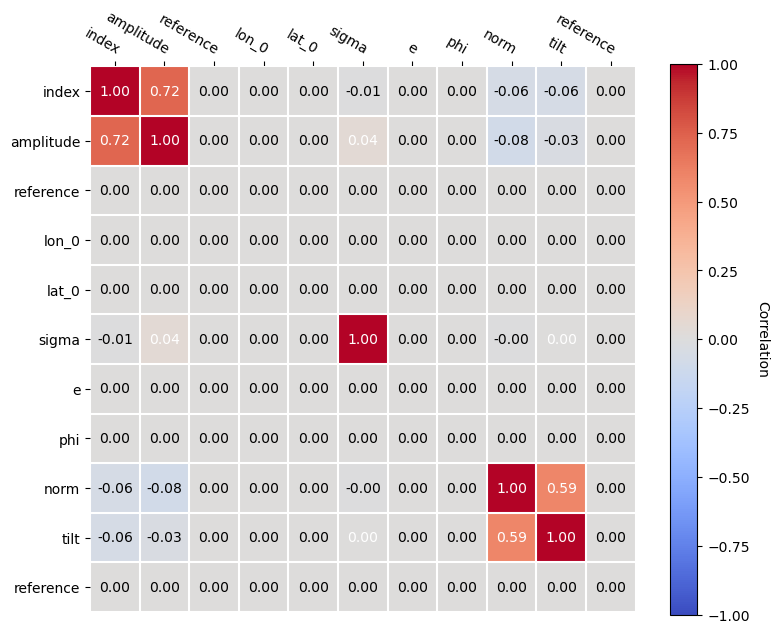

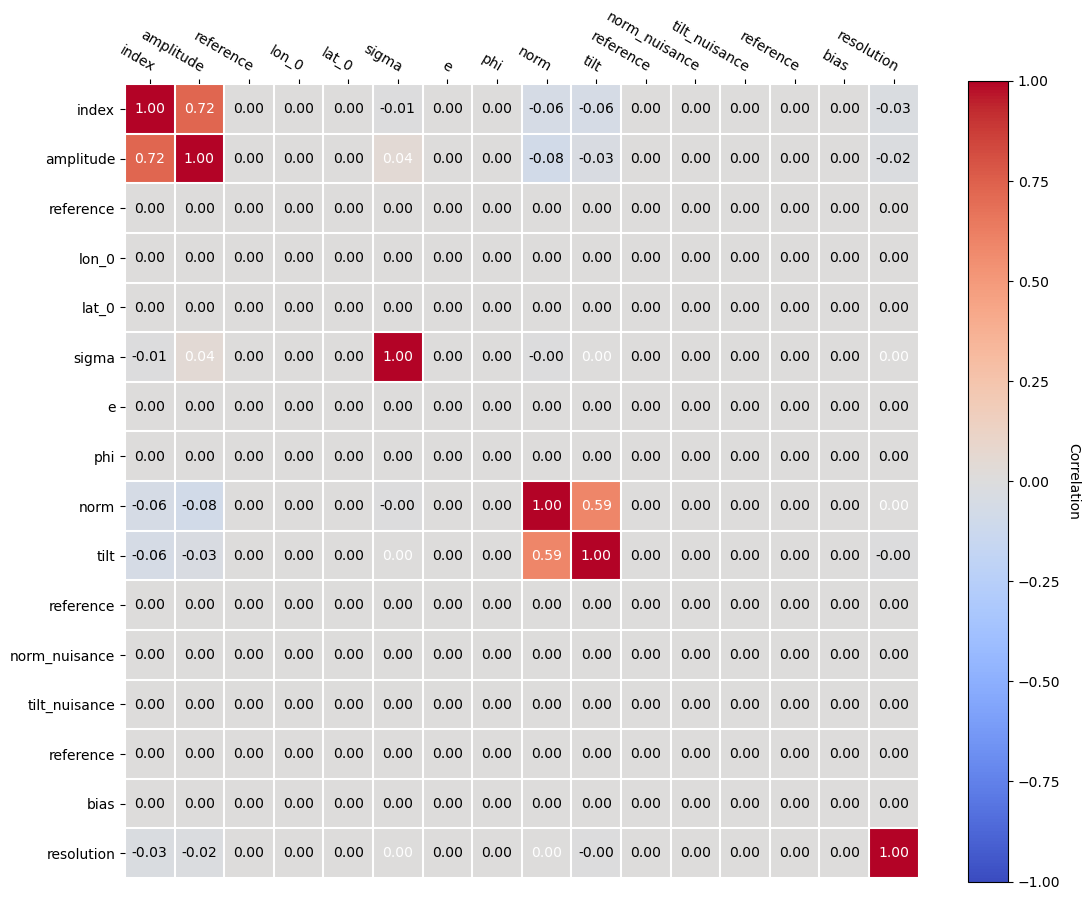

In [12]:
%%time
print("corr")
fit_cor = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_cor.optimize_opts = minuit_opts
result_cor = fit_cor.run(dataset_asimov)
dataset_asimov.models.covariance = fit_cor.covariance(dataset_asimov).matrix
dataset_asimov.models.covariance.plot_correlation()
print(fit_cor.minuit)

fit_cor_N = Fit(store_trace=False)
fit_cor_N.optimize_opts = {"tol": 0.001, "strategy": 2}
result_cor_N = fit_cor_N.run(dataset_asimov_N)
dataset_asimov_N.models.covariance = fit_cor_N.covariance(dataset_asimov_N).matrix
dataset_asimov_N.models.covariance.plot_correlation()
print(fit_cor_N.minuit)
    




        

In [13]:
valuies_asimov = [[dataset_asimov.models[1].parameters['norm'].value, 
                   dataset_asimov.models[1].parameters['norm'].error],
                  [dataset_asimov.models[0].parameters['amplitude'].value, 
                   dataset_asimov.models[0].parameters['amplitude'].error],
                  [dataset_asimov.models[0].parameters['index'].value, 
                   dataset_asimov.models[0].parameters['index'].error],]


valuies_asimov_N = [[dataset_asimov_N.models[1].parameters['norm'].value, 
                   dataset_asimov_N.models[1].parameters['norm'].error],
                  [dataset_asimov_N.models[0].parameters['amplitude'].value, 
                   dataset_asimov_N.models[0].parameters['amplitude'].error],
                  [dataset_asimov_N.models[0].parameters['index'].value, 
                   dataset_asimov_N.models[0].parameters['index'].error],]

## Asimov Likelihood

In [14]:
%%time
computing = 1
if computing:

    x = dataset_asimov.models.parameters['amplitude']
    y = dataset_asimov.models.parameters['index']
    x.scan_n_sigma = 5
    y.scan_n_sigma = 2
    x.scan_n_values = 6
    y.scan_n_values = 5

    contour = fit_cor.stat_surface([dataset_asimov], x, y, reoptimize=True) 

    contour_write = dict()
    for k in contour.keys():
        print(k)
        if k != 'fit_results':
            contour_write[k]  = contour[k].tolist()
            
    with open('data/7c_contour.yml' , 'w') as outfile:
        yaml.dump(contour_write, outfile, default_flow_style=False)
        
else:
    with open('data/7c_contour.yml', 'r') as stream:
        contour=yaml.safe_load(stream)
        
amplix__ = contour['Source.spectral.amplitude_scan']
indexy__ = contour['Source.spectral.index_scan']
N_new = 110
N_new_y = 100

amplix__new =  np.linspace(amplix__[0], amplix__[-1],N_new)
indexy__new =  np.linspace(indexy__[0], indexy__[-1],N_new_y)


f = interp2d(x = indexy__, y= amplix__, z = contour['stat_scan'], kind='cubic',fill_value = None, bounds_error = False )
data_contour = f(indexy__new, amplix__new)



Source.spectral.amplitude_scan
Source.spectral.index_scan
stat_scan
fit_results
CPU times: user 59.3 s, sys: 50.7 ms, total: 59.3 s
Wall time: 59.3 s


min index: 2.330245501192939
min amplitude: 1.0183267360334382e-12


Text(0.5, 1.0, 'Likelihood')

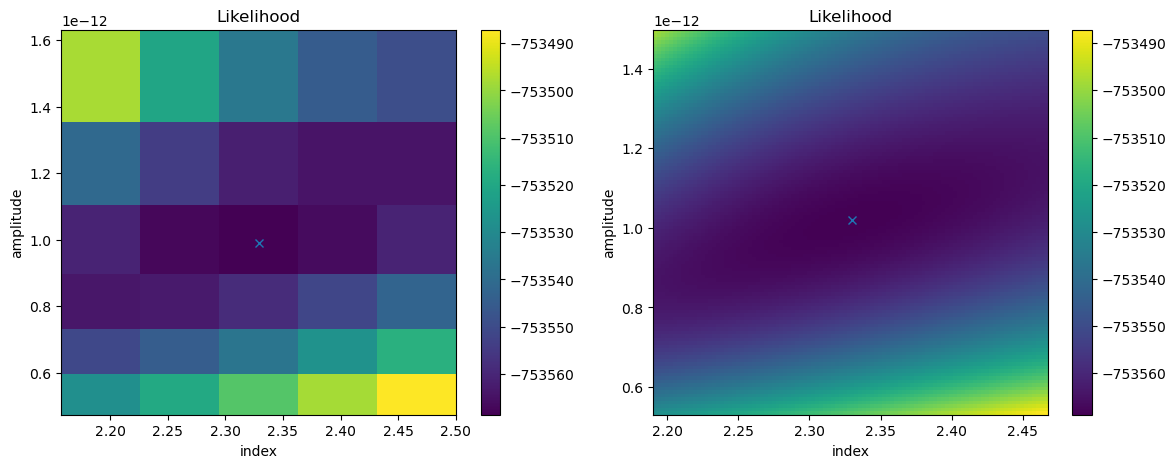

In [15]:
fig, (ax1, ax) = plt.subplots(1,2, figsize = (14,5))


im =ax1.pcolormesh(indexy__, amplix__, contour['stat_scan'])
dddd = np.array(contour['stat_scan'])
ampli_best = amplix__[np.where(dddd == dddd.min())[0][0]]
index_best = indexy__[np.where(dddd == dddd.min())[1][0]]

ax1.plot(index_best, ampli_best, 'x')
fig.colorbar(im, ax=ax1)
ax1.set_ylabel("amplitude")
ax1.set_xlabel("index",)
ax1.set_title(f"Likelihood")


im =ax.pcolormesh(indexy__new, amplix__new, data_contour)
dddd = np.array(data_contour)
ampli_best = amplix__new[np.where(dddd == dddd.min())[0][0]]
index_best = indexy__new[np.where(dddd == dddd.min())[1][0]]
print("min index:", index_best)
print("min amplitude:", ampli_best)

ax.plot(index_best, ampli_best, 'x')
fig.colorbar(im, ax=ax)
ax.set_ylabel("amplitude")
ax.set_xlabel("index",)
ax.set_title(f"Likelihood")

2.331631432492705 1.0227218891338847e-12
2.331631432492705 1.0227218891338847e-12


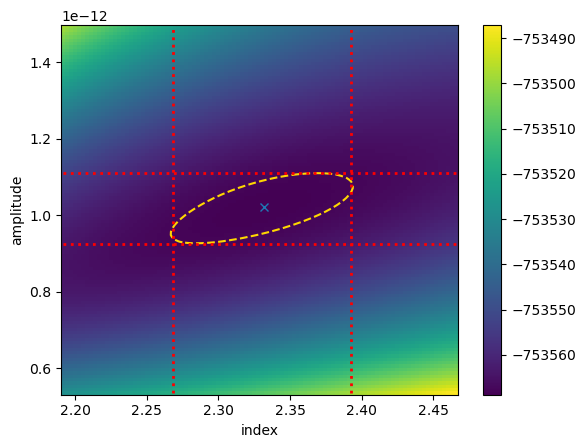

In [16]:
threshold_contour = 1
ampli_min_asimov,  ampli_max_asimov, index_min_asimov, index_max_asimov,  ampli_best_asimov, index_best_asimov = compute_errors(
    data_contour, indexy__new, amplix__new,  threshold_contour, find_min = True)

CS= plot_L(data_contour, indexy__new, amplix__new,  threshold_contour,
      find_min = True, color = 'red')

dat= CS.allsegs[0][0]

## Asimov Likelihood N

In [17]:
%%time
if computing:
    x_N = dataset_asimov_N.models.parameters['amplitude']
    y_N = dataset_asimov_N.models.parameters['index']

    x_N.scan_values = x.scan_values
    y_N.scan_values = y.scan_values

    contour_N = fit_cor.stat_surface([dataset_asimov_N], x_N, y_N, reoptimize=True ) 


    contour_write = dict()
    for k in contour_N.keys():
        print(k)
        if k != 'fit_results':
            contour_write[k]  = contour_N[k].tolist()
            
    with open('data/7c_contour_N.yml' , 'w') as outfile:
        yaml.dump(contour_write, outfile, default_flow_style=False)
        
else:
    with open('data/7c_contour_N.yml', 'r') as stream:
        contour_N=yaml.safe_load(stream)
        
#print(contour_N)
amplix___N = contour_N['Source.spectral.amplitude_scan']
indexy___N = contour_N['Source.spectral.index_scan']
amplix__new_N =  np.linspace(amplix___N[0], amplix___N[-1],N_new)
indexy__new_N =  np.linspace(indexy___N[0], indexy___N[-1],N_new_y)    
        

f = interp2d(x = indexy___N, y= amplix___N, z = contour_N['stat_scan'], kind='cubic',fill_value = None, bounds_error = False )
data_contour_N = f(indexy__new_N, amplix__new_N)

evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.13455121845872794 0.0
evaluate: -0.12871432964013424 0.0
evaluate: 0.05230278144810278 0.0
evaluate: -0.046465892629509085 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.05230278144810278 0.0
evaluate: -0.046465892629509085 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444409296843 0.0
evaluate: 0.002918444

evaluate: 0.0014858956789164904 0.0
evaluate: 0.00148644291257652 0.0
evaluate: 0.0014864702742595215 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.05074174188075121 0.0
evaluate: -0.04776879845205501 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.0014864717143481005 0.0
evaluate: 0.011337525747628722 0.0
evaluate: -0.008364582318932522 0.0
evaluate: 0.0034566825210042254 0.0
evaluate: -0.00048373909230802403 

evaluate: 0.001189702188630911 0.0
evaluate: 0.001189702188630911 0.0
evaluate: 0.001189702188630911 0.0
evaluate: 0.001189702188630911 0.0
evaluate: 0.0914896290681443 0.0
evaluate: -0.08911022469088246 0.0
evaluate: 0.002691750684656931 0.0
evaluate: 0.0018837764337823787 0.0
evaluate: 0.0015176261448011626 0.0
evaluate: 0.0013452138415699095 0.0
evaluate: 0.001262599420616931 0.0
evaluate: 0.0012266897916423235 0.0
evaluate: 0.0013374382589229597 0.0
evaluate: 0.0013000188397699452 0.0
evaluate: 0.0012264772832108126 0.0
evaluate: 0.0012922432571229954 0.0
evaluate: 0.001277421338869963 0.0
evaluate: 0.001262599420616931 0.0
evaluate: 0.001262599420616931 0.0
evaluate: 0.001262599420616931 0.0
evaluate: 0.001262599420616931 0.0
evaluate: 0.001262599420616931 0.0
evaluate: 0.001262599420616931 0.0
evaluate: 0.048565900063108985 0.0
evaluate: -0.046040701221875126 0.0
evaluate: 2.1070258856872305e-05 0.0
evaluate: 0.001200522962528928 0.0
evaluate: 0.0012594955977125307 0.0
evaluate: 

evaluate: 0.0010411486131341721 0.0
evaluate: 0.0010411486131341721 0.0
evaluate: 0.13267132461219372 0.0
evaluate: -0.1305890273859254 0.0
evaluate: 0.047968613225956046 0.0
evaluate: -0.04588631599968771 0.0
evaluate: 0.0010411486131341721 0.0
evaluate: 0.0010411486131341721 0.0
evaluate: 0.0010411486131341721 0.0
evaluate: 0.0010411486131341721 0.0
evaluate: 0.0010411486131341721 0.0
evaluate: 0.0010411486131341721 0.0
evaluate: 0.0010411486131341721 0.0
evaluate: 0.047968613225956046 0.0
evaluate: -0.04588631599968771 0.0
evaluate: 0.0010411486131341721 0.0
evaluate: 0.0010411486131341721 0.0
evaluate: 0.0010411486131341721 0.0
evaluate: 0.0010411486131341721 0.0
evaluate: 0.0010411486131341721 0.0
evaluate: 0.0010411486131341721 0.0
evaluate: 0.0010411486131341721 0.0
evaluate: 0.0010411486131341721 0.0
evaluate: 0.010426641535698548 0.0
evaluate: -0.008344344309430204 0.0
evaluate: 0.0029182471976470473 0.0
evaluate: -0.0008359499713787033 0.0
evaluate: 0.0010411486131341721 0.0


evaluate: -0.003629164149965931 0.0
evaluate: -0.0014336625630111514 0.0
evaluate: -0.00045251721546536196 0.0
evaluate: 1.3342244710458574e-05 0.0
evaluate: 0.00024783702590828923 0.0
evaluate: 0.0003040824284278767 0.0
evaluate: 3.6631810642810516e-05 0.0
evaluate: 3.6631810642810516e-05 0.0
evaluate: 3.6631810642810516e-05 0.0
evaluate: 3.6631810642810516e-05 0.0
evaluate: 3.6631810642810516e-05 0.0
evaluate: 3.6631810642810516e-05 0.0
evaluate: 3.6631810642810516e-05 0.0
evaluate: 0.0793674596519921 0.0
evaluate: -0.07929419603070648 0.0
evaluate: -0.004143190875415104 0.0
evaluate: -0.001791110193921258 0.0
evaluate: -0.0008218806547854186 0.0
evaluate: -0.0003793660127875944 0.0
evaluate: -0.00016832698328898658 0.0
evaluate: -6.384924165074553e-05 0.0
evaluate: -1.1125945030062562e-05 0.0
evaluate: 1.4378165591775689e-05 0.0
evaluate: 2.7688381228647432e-05 0.0
evaluate: 3.273696327625186e-05 0.0
evaluate: 3.523219462193912e-05 0.0
evaluate: 3.523219462193912e-05 0.0
evaluate: 3

evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 0.024391111767066653 0.0
evaluate: 1.4108330396447856e-06 0.0
evaluate: 0.024391111767066653 0.0
evaluate: 0.024391111767066653 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 0.024390630325386284 0.0
evaluate: -0.024387808659306995 0.0
evaluate: -2.6274221685934633e-09 0.0
evaluate: 9.28633784024075e-07 0.0
evaluate: 1.2111505309885519e-06 0.0
evaluate: 1.322009216164194e-06 0.0
evaluate: 1.3705482635493889e-06 0.0
evaluate: 1.3924928815748373e-06 0.0
evaluate: 1.4023853006631433e-06 0.0
evaluate: 1.4072189400067222e-06 0.0
evaluate: 1.

evaluate: 0.024390630318066715 0.0
evaluate: 0.024390630318066715 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 0.0031115018571176477 0.0
evaluate: -0.00310868019103836 0.0
evaluate: 0.00245651171898383 0.0
evaluate: -0.0024536900529045424 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 1.4108330396439803e-06 0.0
evaluate: 0.00245651171898383 0.0
evaluate: -0.0024536900529045424 0.0
evaluate: 1.41

evaluate: 7.225961321489168e-09 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 2.4559827957964887e-05 0.0
evaluate: -2.4545376035321912e-05 0.0
evaluate: 7.514378430956005e-09 0.0
evaluate: 7.240382176962509e-09 0.0
evaluate: 7.226682364262834e-09 0.0
evaluate: 7.2259973736278505e-09 0.0
evaluate: 7.2259634367652545e-09 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 2.4559827957964887e-05 0.0
evaluate: -2.4545376035321912e-05 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 7.225961321489168e-09 0.0
evaluate: 7.22596132

evaluate: 2.241293197417961e-08 0.0
evaluate: 2.241293197417961e-08 0.0
evaluate: 2.241293197417961e-08 0.0
evaluate: 2.241293197417961e-08 0.0
evaluate: 2.241293197417961e-08 0.0
evaluate: 3.112332317275423e-05 0.0
evaluate: -3.107849730880587e-05 0.0
evaluate: 1.8173284735393202e-08 0.0
evaluate: 2.070807024185119e-08 0.0
evaluate: 2.1640252693652097e-08 0.0
evaluate: 2.204469292168603e-08 0.0
evaluate: 2.2234362006120067e-08 0.0
evaluate: 2.2325212543139305e-08 0.0
evaluate: 2.2369153641561292e-08 0.0
evaluate: 2.2391657997473274e-08 0.0
evaluate: 2.2403002798577663e-08 0.0
evaluate: 2.2405088227766874e-08 0.0
evaluate: 2.2403002798577663e-08 0.0
evaluate: 2.2403002798577663e-08 0.0
evaluate: 2.2403002798577663e-08 0.0
evaluate: 2.2403002798577663e-08 0.0
evaluate: 2.2403002798577663e-08 0.0
evaluate: 2.2403002798577663e-08 0.0
evaluate: 2.4574678827747962e-05 0.0
evaluate: -2.4529872822150806e-05 0.0
evaluate: 2.233545294494976e-08 0.0
evaluate: 2.2369370637023396e-08 0.0
evaluate:

evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: 4.801990044089563e-06 0.0
evaluate: -5.019226210419211e-06 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: 2.444442255310711e-05 0.0
evaluate: -1.0861808316482439e-07 0.0
evaluate: 2.444442255310711e-05 0.0
evaluate: 2.444442255310711e-05 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.0861808316482385e-07 0.0
evaluate: -1.08618083

evaluate: -1.086036764057063e-07 0.0
evaluate: -1.086036764057063e-07 0.0
evaluate: -1.086036764057063e-07 0.0
evaluate: -1.086036764057063e-07 0.0
evaluate: -1.086036764057063e-07 0.0
evaluate: -1.086036764057063e-07 0.0
evaluate: -1.086036764057063e-07 0.0
evaluate: -1.086036764057063e-07 0.0
evaluate: -1.086036764057063e-07 0.0
evaluate: 0.005000025045816737 0.0
evaluate: -0.005000242253169548 0.0
evaluate: 0.0004999047612729086 0.0
evaluate: -0.00050012196862572 0.0
evaluate: -8.685655544378435e-10 0.0
evaluate: -7.077354502273742e-08 0.0
evaluate: -9.249237996407322e-08 0.0
evaluate: -1.0119717658993693e-07 0.0
evaluate: -1.0509127254778443e-07 0.0
evaluate: -1.0691481838488528e-07 0.0
evaluate: -1.077935847123392e-07 0.0
evaluate: -1.082077724611929e-07 0.0
evaluate: -1.0841741515868071e-07 0.0
evaluate: -1.0851507198376653e-07 0.0
evaluate: -1.0856362382199229e-07 0.0
evaluate: -1.086036764057063e-07 0.0
evaluate: -1.086036764057063e-07 0.0
evaluate: -1.086036764057063e-07 0.0
e

evaluate: 1.0936311490940014e-08 0.0
evaluate: 1.0936311490940014e-08 0.0
evaluate: 1.0936311490940014e-08 0.0
evaluate: 1.0936311490940014e-08 0.0
evaluate: 1.0936311490940014e-08 0.0
evaluate: 1.0936311490940014e-08 0.0
evaluate: 1.0936311490940014e-08 0.0
evaluate: 3.111184655227099e-05 0.0
evaluate: -3.108997392928911e-05 0.0
evaluate: 9.904209887710481e-09 0.0
evaluate: 1.0529903443622016e-08 0.0
evaluate: 1.0755019518595927e-08 0.0
evaluate: 1.0851175921601222e-08 0.0
evaluate: 1.0895279027132287e-08 0.0
evaluate: 1.091641316479556e-08 0.0
evaluate: 1.0926403589966715e-08 0.0
evaluate: 1.0927888795087778e-08 0.0
evaluate: 1.0926403589966715e-08 0.0
evaluate: 1.0926403589966715e-08 0.0
evaluate: 1.0926403589966715e-08 0.0
evaluate: 1.0926403589966715e-08 0.0
evaluate: 1.0926403589966715e-08 0.0
evaluate: 1.0926403589966715e-08 0.0
evaluate: 2.456388056590456e-05 0.0
evaluate: -2.454202775872463e-05 0.0
evaluate: 1.0357319134420382e-08 0.0
evaluate: 1.0637312279058599e-08 0.0
evalu

evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: 4.9047783602328336e-06 0.0
evaluate: -4.916357711908416e-06 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: 2.454705050451533e-05 0.0
evaluate: -5.789675837791038e-09 0.0
evaluate: 2.454705050451533e-05 0.0
evaluate: 2.454705050451533e-05 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.78967583779161e-09 0.0
evaluate: -5.789675837791

evaluate: 2.5536423337608636e-08 0.0
evaluate: 2.5536423337608636e-08 0.0
evaluate: 1.7387110296271314e-05 0.0
evaluate: -1.73360374495961e-05 0.0
evaluate: 2.5536423337608636e-08 0.0
evaluate: 2.5536423337608636e-08 0.0
evaluate: 0.00031103463883113807 0.0
evaluate: 2.5536423337616725e-08 0.0
evaluate: 0.00031103463883113807 0.0
evaluate: 0.00031103463883113807 0.0
evaluate: 8.271572592634122e-08 0.0
evaluate: 8.939153302111818e-08 0.0
evaluate: 9.360378026743618e-08 0.0
evaluate: 9.360378026743618e-08 0.0
evaluate: 9.360378026743618e-08 0.0
evaluate: 9.360378026743618e-08 0.0
evaluate: 9.360378026743618e-08 0.0
evaluate: 9.360378026743618e-08 0.0
evaluate: 9.360378026743618e-08 0.0
evaluate: 9.360378026743618e-08 0.0
evaluate: 9.360378026743618e-08 0.0
evaluate: 3.119451402104749e-05 0.0
evaluate: -3.1007306460512616e-05 0.0
evaluate: 1.1732583301393481e-07 0.0
evaluate: 1.1732583301393481e-07 0.0
evaluate: 1.1732583301393481e-07 0.0
evaluate: 1.1732583301393481e-07 0.0
evaluate: 1.1

evaluate: -2.3676532793105547e-06 0.0
evaluate: -2.3676532793105547e-06 0.0
evaluate: -2.3676532793105547e-06 0.0
evaluate: -2.3676532793105547e-06 0.0
evaluate: -2.3676532793105547e-06 0.0
evaluate: -2.3676532793105547e-06 0.0
evaluate: -2.3676532793105547e-06 0.0
evaluate: 0.004963438388645543 0.0
evaluate: -0.0049681736952041635 0.0
evaluate: 0.0004942129509131748 0.0
evaluate: -0.0004989482574717959 0.0
evaluate: -2.274111659486806e-08 0.0
evaluate: -1.8063910890179526e-06 0.0
evaluate: -2.2037803332066202e-06 0.0
evaluate: -2.317357521925338e-06 0.0
evaluate: -2.3524542278435953e-06 0.0
evaluate: -2.3628307780881703e-06 0.0
evaluate: -2.3664436417665993e-06 0.0
evaluate: -2.3674306671029102e-06 0.0
evaluate: -2.367637066622667e-06 0.0
evaluate: -2.3675485590484633e-06 0.0
evaluate: -2.367603868228647e-06 0.0
evaluate: -2.367637066622667e-06 0.0
evaluate: -2.367637066622667e-06 0.0
evaluate: -2.367637066622667e-06 0.0
evaluate: -2.367637066622667e-06 0.0
evaluate: -2.36763706662266

evaluate: -1.8050322325833116e-05 0.0
evaluate: -1.8050322325833116e-05 0.0
evaluate: -1.8050322325833116e-05 0.0
evaluate: -1.8050322325833116e-05 0.0
evaluate: -1.8050322325833116e-05 0.0
evaluate: -1.8050322325833116e-05 0.0
evaluate: -1.8050322325833116e-05 0.0
evaluate: -1.8050322325833116e-05 0.0
evaluate: -1.8050322325833116e-05 0.0
evaluate: -1.8050322325833116e-05 0.0
evaluate: 0.004981806125891894 0.0
evaluate: -0.005017906770543561 0.0
evaluate: 0.0004819353224959397 0.0
evaluate: -0.000518035967147606 0.0
evaluate: 6.1864134630195625e-09 0.0
evaluate: -1.377355264028203e-05 0.0
evaluate: -1.6817271377947697e-05 0.0
evaluate: -1.7675548809447793e-05 0.0
evaluate: -1.7940234742574667e-05 0.0
evaluate: -1.8014618152661972e-05 0.0
evaluate: -1.803817233914991e-05 0.0
evaluate: -1.804866562787597e-05 0.0
evaluate: -1.8050239490935257e-05 0.0
evaluate: -1.8050318184088223e-05 0.0
evaluate: -1.8050322325833116e-05 0.0
evaluate: -1.8050322325833116e-05 0.0
evaluate: -1.805032232583

evaluate: 7.326491881041816e-06 0.0
evaluate: 7.34012769007033e-06 0.0
evaluate: 7.346540808403693e-06 0.0
evaluate: 7.349868669641486e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 0.024397312661229804 0.0
evaluate: -0.024382608394558535 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 0.004885344238914468 0.0
evaluate: -0.0048706399722432 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 0.024397312661229804 0.0
evaluate: 7.35213333563479e-06 0.0
evaluate: 0.024397312661229804 0.0


evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 0.0031174431574136374 0.0
evaluate: -0.0031027388907423703 0.0
evaluate: 0.0024624914653745187 0.0
evaluate: -0.0024477871987032516 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 0.0024624914653745187 0.0
evaluate: -0.0024477871987032516 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.352133335633411e-06 0.0
evaluate: 7.3521333356334

evaluate: 1.2161466021223941e-08 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 3.1113071706801275e-05 0.0
evaluate: -3.108874877475882e-05 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 6.2323435141772346e-06 0.0
evaluate: -6.208020582134787e-06 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 3.1113071706801275e-05 0.0
evaluate: 1.2161466021225352e-08 0.0
evaluate: 3.1113071706801275e-05 0.0
evaluate: 3.1113071706801275e-05 0.0
evaluate: 1.2161466021223941e-08 0.0
evaluate: 1.2161466021223941e-08 0.0
e

evaluate: 1.2161174393175962e-08 0.0
evaluate: 1.2161174393175962e-08 0.0
evaluate: 1.2161174393175962e-08 0.0
evaluate: 1.2161174393175962e-08 0.0
evaluate: 1.2161174393175962e-08 0.0
evaluate: 0.004999984071980975 0.0
evaluate: -0.004999959749632189 0.0
evaluate: 0.0005000093522550515 0.0
evaluate: -0.0004999850299062651 0.0
evaluate: -7.877382225223375e-09 0.0
evaluate: 5.157167703796396e-09 0.0
evaluate: 9.200854443976615e-09 0.0
evaluate: 1.0812412907193625e-08 0.0
evaluate: 1.1526742246588865e-08 0.0
evaluate: 1.1858279254558883e-08 0.0
evaluate: 1.2016390312075773e-08 0.0
evaluate: 1.2091921705269322e-08 0.0
evaluate: 1.2128064039126057e-08 0.0
evaluate: 1.2146717643303283e-08 0.0
evaluate: 1.215521222030225e-08 0.0
evaluate: 1.2161174393175962e-08 0.0
evaluate: 1.2161174393175962e-08 0.0
evaluate: 1.2161174393175962e-08 0.0
evaluate: 1.2161174393175962e-08 0.0
evaluate: 1.2161174393175962e-08 0.0
evaluate: 1.2161174393175962e-08 0.0
evaluate: 1.2161174393175962e-08 0.0
evaluate

evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: 0.0050000129959484356 0.0
evaluate: -0.0050000520865569 0.0
evaluate: 0.0004999837088210346 0.0
evaluate: -0.0005000227994294991 0.0
evaluate: 9.575531603016194e-09 0.0
evaluate: -9.596423200113059e-09 0.0
evaluate: -1.540096303892482e-08 0.0
evaluate: -1.7711511179975873e-08 0.0
evaluate: -1.8708657215548258e-08 0.0
evaluate: -1.9157495171061e-08 0.0
evaluate: -1.9365472851766002e-08 0.0
evaluate: -1.946051440807983e-08 0.0
evaluate: -1.9505803165087217e-08 0.0
evaluate: -1.9528912417105997e-08 0.0
evaluate: -1.953886604188874e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e

evaluate: 0.0003109895571035682 0.0
evaluate: -0.0003110286477120327 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: 1.7341696393270207e-05 0.0
evaluate: -1.7380787001734645e-05 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: -1.9545304232217217e-08 0.0
evaluate: 0.0003109895571035682 0.0
evaluate: -1.954530423223332e-08 0.0
evaluate: 0.0003109895571035682 0.0
evaluate: 0.0003109895571035682 0.0
evaluate: -3.831025894234155e-09 0.0
evaluate: -1.7308061567210608e-09 0.0
evaluate: -2.8865245924001502e-09 0.0
evaluate: -8.240241758414946e-08 0.0
evaluate: -4.311672173919181e-08 0.0
evaluate: -2.3473873816712984e-08 0.0
evaluate: -1.365244985547357e-08 0.0
evaluate: -8.74173787485386e-09 0.0
evaluate: -6.286381884544008e

evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: 4.83007403354345e-06 0.0
evaluate: -4.991080581875104e-06 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: -8.050327416582686e-08 0.0
evaluate: 2.447238326438056e-05 0.0
evaluate: -8.050327416582604e-08 0.0
evaluate: 2.447238326438056e-05 0.0
evaluate: 2.447238326438056e-05 0.0
evaluate: -8.050327416582686e-08 0.0
evalua

evaluate: -3.909363190541044e-08 0.0
evaluate: -3.909363190541044e-08 0.0
evaluate: -3.909363190541044e-08 0.0
evaluate: 3.106181660887464e-05 0.0
evaluate: -3.114000387268546e-05 0.0
evaluate: -3.8196396475507634e-08 0.0
evaluate: -3.862606544260428e-08 0.0
evaluate: -3.862606544260428e-08 0.0
evaluate: -3.862606544260428e-08 0.0
evaluate: -3.862606544260428e-08 0.0
evaluate: -3.862606544260428e-08 0.0
evaluate: -3.862606544260428e-08 0.0
evaluate: -3.862606544260428e-08 0.0
evaluate: 2.4514426359107788e-05 0.0
evaluate: -2.4591678489992995e-05 0.0
evaluate: -3.995951285782116e-08 0.0
evaluate: -3.906810705818468e-08 0.0
evaluate: -3.881716548758769e-08 0.0
evaluate: -3.87097878351759e-08 0.0
evaluate: -3.866401644533871e-08 0.0
evaluate: -3.864353329224588e-08 0.0
evaluate: -3.8634199332000587e-08 0.0
evaluate: -3.8629854935003283e-08 0.0
evaluate: -3.862792943419635e-08 0.0
evaluate: -3.8626962602222e-08 0.0
evaluate: -3.8626962602222e-08 0.0
evaluate: -3.8626962602222e-08 0.0
evalu

evaluate: -3.6394341624013594e-08 0.0
evaluate: -3.6475167827349534e-08 0.0
evaluate: -3.651206527441256e-08 0.0
evaluate: -3.652837092644682e-08 0.0
evaluate: -3.6534663933076835e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: 0.0004999601155973293 0.0
evaluate: -0.0005000331912047826 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537803726652876e-08 0.0
evaluate: -3.6537

evaluate: 3.7760509148665375e-08 0.0
evaluate: 3.734052328028006e-08 0.0
evaluate: 3.734052328028006e-08 0.0
evaluate: 3.734052328028006e-08 0.0
evaluate: 3.734052328028006e-08 0.0
evaluate: 3.734052328028006e-08 0.0
evaluate: 3.734052328028006e-08 0.0
evaluate: 3.734052328028006e-08 0.0
evaluate: 2.4590390106534624e-05 0.0
evaluate: -2.451570905997406e-05 0.0
evaluate: 3.843642514927022e-08 0.0
evaluate: 4.282003262523087e-08 0.0
evaluate: 3.953248027107428e-08 0.0
evaluate: 3.953248027107428e-08 0.0
evaluate: 3.953248027107428e-08 0.0
evaluate: 3.953248027107428e-08 0.0
evaluate: 3.953248027107428e-08 0.0
evaluate: 3.953248027107428e-08 0.0
evaluate: 3.953248027107428e-08 0.0
evaluate: 2.459258219618478e-05 0.0
evaluate: -2.4513517235642636e-05 0.0
evaluate: 3.8098287119007405e-08 0.0
evaluate: 3.90861067794623e-08 0.0
evaluate: 3.935850131827048e-08 0.0
evaluate: 3.9459523792713526e-08 0.0
evaluate: 3.9500950074408617e-08 0.0
evaluate: 3.95187694232512e-08 0.0
evaluate: 3.9526352564

evaluate: 1.2622421229479806e-05 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 0.0005125895167904738 0.0
evaluate: -0.0004873446743315142 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 2.9984049184546958e-05 0.0
evaluate: -4.739206725587346e-06 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 0.0005125895167904738 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 0.0005125895167904738 0.0
evaluate: 0.0005125895167904738 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 1.2622421229479806e-05 0.0
evaluate: 1.2622421229479806e-05 0.0
evalu

evaluate: -0.00017921148926392864 0.0
evaluate: -0.00022711459008629693 0.0
evaluate: -0.00023889464930011337 0.0
evaluate: -0.00024293965568897866 0.0
evaluate: -0.00024360034078136958 0.0
evaluate: -0.00024363337503598912 0.0
evaluate: -0.00024363502674872012 0.0
evaluate: -0.00024363490100112048 0.0
evaluate: -0.00024363346196823815 0.0
evaluate: -0.00024363418148467931 0.0
evaluate: -0.00024363490100112048 0.0
evaluate: -0.00024363490100112048 0.0
evaluate: -0.00024363490100112048 0.0
evaluate: -0.00024363490100112048 0.0
evaluate: -0.00024363490100112048 0.0
evaluate: -0.00024363490100112048 0.0
evaluate: 0.02414519235469913 0.0
evaluate: -0.024632462156701368 0.0
evaluate: 0.00015763502712264277 0.0
evaluate: 0.00015763502712264277 0.0
evaluate: 0.00015763502712264277 0.0
evaluate: 0.00015763502712264277 0.0
evaluate: 0.00015763502712264277 0.0
evaluate: 0.00015763502712264277 0.0
evaluate: 0.00015763502712264277 0.0
evaluate: 0.024546462379673787 0.0
evaluate: -0.024231192325428

evaluate: 9.39107356128922e-05 0.0
evaluate: 9.39107356128922e-05 0.0
evaluate: 9.39107356128922e-05 0.0
evaluate: 0.024230643155528447 0.0
evaluate: -0.02404282168430266 0.0
evaluate: 9.39107356128922e-05 0.0
evaluate: 9.39107356128922e-05 0.0
evaluate: 9.39107356128922e-05 0.0
evaluate: 9.39107356128922e-05 0.0
evaluate: 9.39107356128922e-05 0.0
evaluate: 9.39107356128922e-05 0.0
evaluate: 0.004921257219596003 0.0
evaluate: -0.0047334357483702185 0.0
evaluate: 9.39107356128922e-05 0.0
evaluate: 9.39107356128922e-05 0.0
evaluate: 0.024230643155528447 0.0
evaluate: 9.391073561289432e-05 0.0
evaluate: 0.024230643155528447 0.0
evaluate: 0.024230643155528447 0.0
evaluate: -1.7267516450072406e-08 0.0
evaluate: -1.7267516450072406e-08 0.0
evaluate: -1.7267516450072406e-08 0.0
evaluate: -1.7267516450072406e-08 0.0
evaluate: -1.7267516450072406e-08 0.0
evaluate: -1.7267516450072406e-08 0.0
evaluate: -1.7267516450072406e-08 0.0
evaluate: 0.024389438231600082 0.0
evaluate: -0.02438947276663298 

evaluate: -4.802220427917e-08 0.0
evaluate: -4.802220427917e-08 0.0
evaluate: -4.802220427917e-08 0.0
evaluate: -4.802220427917e-08 0.0
evaluate: -4.802220427917e-08 0.0
evaluate: -4.802220427917e-08 0.0
evaluate: -4.802220427917e-08 0.0
evaluate: 0.0003109610802035213 0.0
evaluate: -0.00031105712461207966 0.0
evaluate: -4.802220427917e-08 0.0
evaluate: -4.802220427917e-08 0.0
evaluate: -4.802220427917e-08 0.0
evaluate: -4.802220427917e-08 0.0
evaluate: -4.802220427917e-08 0.0
evaluate: -4.802220427917e-08 0.0
evaluate: 1.731342973807866e-05 0.0
evaluate: -1.7409474146637e-05 0.0
evaluate: -4.802220427917e-08 0.0
evaluate: -4.802220427917e-08 0.0
evaluate: 0.0003109610802035213 0.0
evaluate: -4.8022204279186556e-08 0.0
evaluate: 0.0003109610802035213 0.0
evaluate: 0.0003109610802035213 0.0
evaluate: -4.654554738563302e-08 0.0
evaluate: -4.654554738563302e-08 0.0
evaluate: -4.654554738563302e-08 0.0
evaluate: -4.654554738563302e-08 0.0
evaluate: -4.654554738563302e-08 0.0
evaluate: -4.6

min index: 2.330245501192939
min amplitude: 1.0183267360334382e-12


Text(0.5, 1.0, 'Likelihood')

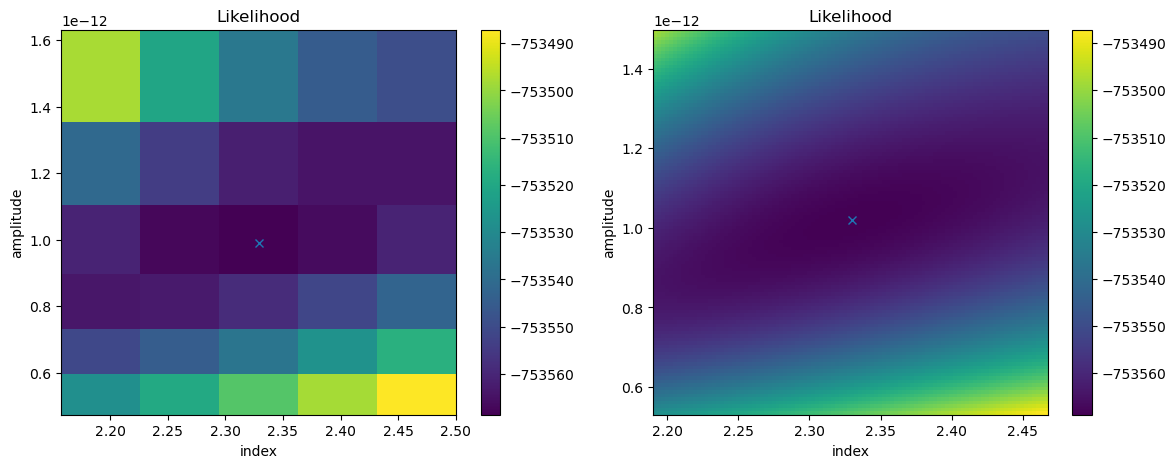

In [18]:
fig, (ax1, ax) = plt.subplots(1,2, figsize = (14,5))

im =ax1.pcolormesh(indexy___N, amplix___N, contour_N['stat_scan'])
dddd = np.array(contour_N['stat_scan'])
ampli_best_N = amplix___N[np.where(dddd == dddd.min())[0][0]]
index_best_N = indexy___N[np.where(dddd == dddd.min())[1][0]]

ax1.plot(index_best_N, ampli_best_N, 'x')
fig.colorbar(im, ax=ax1)
ax1.set_ylabel("amplitude")
ax1.set_xlabel("index",)
ax1.set_title(f"Likelihood")


im =ax.pcolormesh(indexy__new_N, amplix__new_N, data_contour_N)
dddd = np.array(data_contour_N)
ampli_best_N = amplix__new_N[np.where(dddd == dddd.min())[0][0]]
index_best_N = indexy__new_N[np.where(dddd == dddd.min())[1][0]]
print("min index:", index_best_N)
print("min amplitude:", ampli_best_N)

ax.plot(index_best_N, ampli_best_N, 'x')
fig.colorbar(im, ax=ax)
ax.set_ylabel("amplitude")
ax.set_xlabel("index",)
ax.set_title(f"Likelihood")

2.331631432492705 1.0227218891338847e-12
2.331631432492705 1.0227218891338847e-12


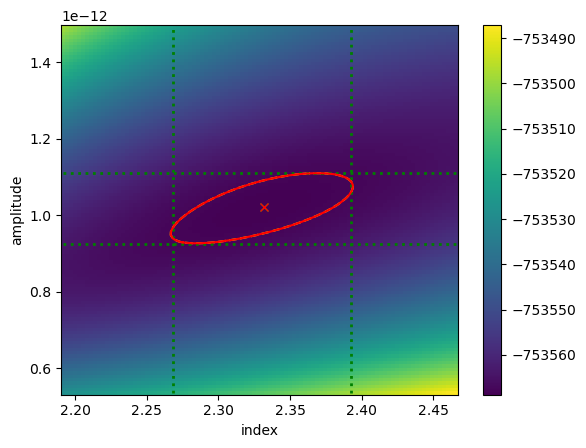

In [19]:
ampli_min_asimov_N,  ampli_max_asimov_N, index_min_asimov_N, index_max_asimov_N, ampli_best_asimov_N, index_best_asimov_N = compute_errors(
    data_contour_N, indexy__new_N, amplix__new_N,  threshold_contour, find_min = True)

CS_N= plot_L(data_contour_N, indexy__new_N, amplix__new_N,  threshold_contour,
      find_min = True, color = 'green')

dat_N = CS_N.allsegs[0][0]
plt.plot(dat[:,0],dat[:,1], color = 'red')
plt.plot(index_best_asimov_N, ampli_best_asimov_N, 'x', color = 'green')
plt.plot(index_best_asimov, ampli_best_asimov, 'x', color = 'red')

## Compute fraction of within

In [20]:
def fraction_within(lower_lim, upper_lim, data):
    is_within = []
    for d in data:
        larger = np.all(d[0] >= lower_lim )
        smaller = np.all(d[0] <= upper_lim)
        is_within.append(larger and smaller)
        
    return (np.count_nonzero(is_within) / len(data))
    

In [21]:
# std best fit, nui best fit, ... 
within_norm = [fraction_within(valuies_asimov[0][0] - valuies_asimov[0][1],
                               valuies_asimov[0][0] +  valuies_asimov[0][1],
                               norms
                              ),
               fraction_within(valuies_asimov_N[0][0] - valuies_asimov_N[0][1],
                               valuies_asimov_N[0][0] + valuies_asimov_N[0][1],
                               norms
                              ),
               0., 0.,
              ]

within_amplitude = [fraction_within(valuies_asimov[1][0] - valuies_asimov[1][1],
                               valuies_asimov[1][0] +  valuies_asimov[1][1],
                               amplitudes
                              ),
               fraction_within(valuies_asimov_N[1][0] - valuies_asimov_N[1][1],
                               valuies_asimov_N[1][0] + valuies_asimov_N[1][1],
                               amplitudes
                              ),
               fraction_within(ampli_min_asimov,
                               ampli_max_asimov,
                               amplitudes
                              ),
                fraction_within(ampli_min_asimov_N,
                               ampli_max_asimov_N,
                               amplitudes
                              ),
                ]

within_index = [fraction_within(valuies_asimov[2][0] - valuies_asimov[2][1],
                               valuies_asimov[2][0] +  valuies_asimov[2][1],
                               indices
                              ),
               fraction_within(valuies_asimov_N[2][0] - valuies_asimov_N[2][1],
                               valuies_asimov_N[2][0] + valuies_asimov_N[2][1],
                               indices
                              ),
                fraction_within(index_min_asimov,
                               index_max_asimov,
                               indices
                              ),
                fraction_within(index_min_asimov_N,
                               index_max_asimov_N,
                               indices
                              ),]

withins = [within_norm, 
          within_amplitude,
          within_index]
print(withins)

NameError: name 'norms' is not defined

NameError: name 'valuies' is not defined

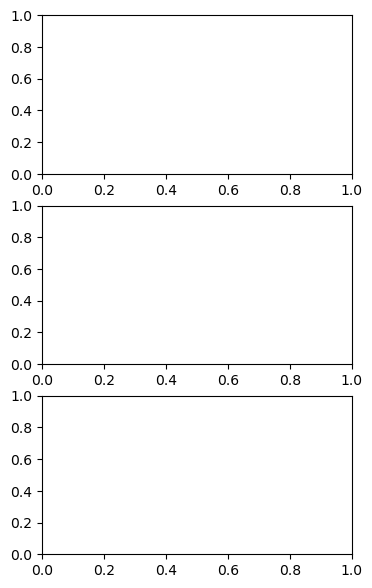

In [22]:
fig, axs = plt.subplots(3,1, figsize = (4,7))
xlabels = ["Best Fit BKG Norm", "Best Fit Amplitude", "Best Fit Index"]
legends = ["Nuisance",'Standard',   ]

for i, v in enumerate(valuies):
    print(i, xlabels[i])
    axs[i].hist(v[1:,0], color ='steelblue', alpha = 0.8)
    ylim = axs[i].get_ylim()
    delta_ylim = 5
    
    axs[i].vlines(valuies_asimov_N[i][0], ylim[0], ylim[1]+ delta_ylim, color = 'green', 
                 linestyle= 'dashed', )
    axs[i].fill_between([valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
                         valuies_asimov_N[i][0] + valuies_asimov_N[i][1]]
                        , ylim[0], ylim[1]+ delta_ylim,
                       alpha = 0.3, color = 'green', 
                        label = legends[0] + f' \n({withins[i][1]*100 :.3}%)')
    axs[i].vlines(valuies_asimov[i][0], ylim[0], ylim[1], color = 'red')
    axs[i].fill_between([valuies_asimov[i][0] - valuies_asimov[i][1],
                         valuies_asimov[i][0] + valuies_asimov[i][1]]
                        , ylim[0], ylim[1],
                       alpha = 0.4 , color = 'red', 
                        label = legends[1] +  f' \n({withins[i][0]*100 :.3}%)'  )
    
    axs[i].set_xlabel(xlabels[i])  
    
    
    x = axs[i].get_xlim()
    deltax = np.max([ valuies_asimov[i][0] - x[0] , x[1] - valuies_asimov[i][0] ])
    axs[i].set_xlim(valuies_asimov[i][0] -deltax, 
                    valuies_asimov[i][0] + deltax)
    
ylim = axs[1].get_ylim()
delta_ylim = 9  
axs[1].vlines(ampli_min_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green',  linestyle = 'dashed') 
axs[1].vlines(ampli_max_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green',  linestyle = 'dashed',
             label=f'({withins[1][3]*100:.3} %)')    
axs[1].vlines(ampli_best_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green',
              linestyle = 'dotted')

delta_ylim = 2
axs[1].vlines(ampli_min_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red',  linestyle = 'dashed') 
axs[1].vlines(ampli_max_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red',  linestyle = 'dashed',
             label=f'({withins[1][2]*100:.3} %)')    
axs[1].vlines(ampli_best_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red',
              linestyle = 'dotted')

ylim = axs[2].get_ylim()
delta_ylim = 9

axs[2].vlines(index_min_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green', linestyle = 'dashed') 
axs[2].vlines(index_max_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green', linestyle = 'dashed',
             label=f'({withins[2][3]*100:.3} %)')   
axs[2].vlines(index_best_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green',
              linestyle = 'dotted')
delta_ylim = 2
axs[2].vlines(index_min_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red', linestyle = 'dashed') 
axs[2].vlines(index_max_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red', linestyle = 'dashed',
             label=f'({withins[2][2]*100:.3} %)') 
axs[2].vlines(index_best_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red',
              linestyle = 'dotted')
plt.tight_layout()
for a in axs:
    a.legend(title="1$\sigma$ eror",loc='center left', bbox_to_anchor=(1, 0.5))



## 2D Histograms Poission

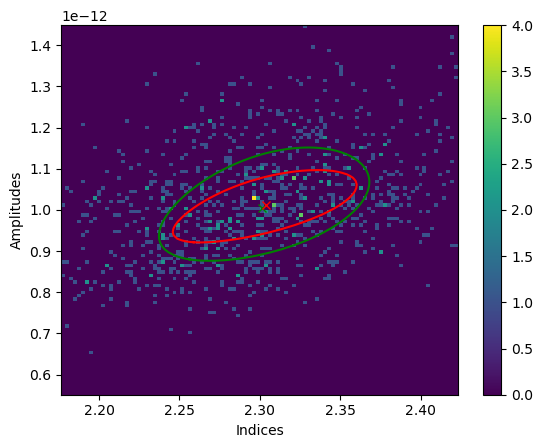

In [58]:
N_bins = N_new + 1
N_bins_y = N_new_y + 1

amplitude_bin = np.linspace(amplix__new_N[0], amplix__new_N[-1], N_bins )
index_bin = np.linspace(indexy__new_N[0], indexy__new_N[-1], N_bins_y )

amplitudes_data = valuies[1][:,0]
indices_data = valuies[2][:,0]
data_N_new, (abins, ibins) = np.histogramdd((amplitudes_data, indices_data), (amplitude_bin, index_bin))

fig, ax = plt.subplots()
im =ax.pcolormesh(ibins, 
           abins,
           data_N_new)

fig.colorbar(im, ax=ax)
ax.plot(index_best_N, ampli_best_N, 'x', color = 'green')
ax.plot(index_best, ampli_best, 'x', color = 'red')

ax.set_ylabel("Amplitudes")
ax.set_xlabel("Indices")
plt.plot(dat[:,0],dat[:,1], color = 'red')
plt.plot(dat_N[:,0],dat_N[:,1], color = 'green')

In [59]:
def compute_inside(Ls_new, x_new,
               y_new, threshold,  find_min = False,  delta=1
                 ):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    outside = Ls_new* (Ls_new < offset)
    inside = Ls_new* (Ls_new >= offset)

    return outside
    

In [60]:
threshold_contour = 1
outside_N = compute_inside(
    data_contour_N, amplix__new_N,
           indexy__new_N,  threshold_contour,  find_min = True, delta =1 )

outside = compute_inside(
    data_contour, amplix__new_N,
           indexy__new_N, threshold_contour,  find_min = True, delta =1 )

outside_N = outside_N <-1.0
outside = outside <-1.0



Text(0.5, 1.0, 'Likelihood 0.227')

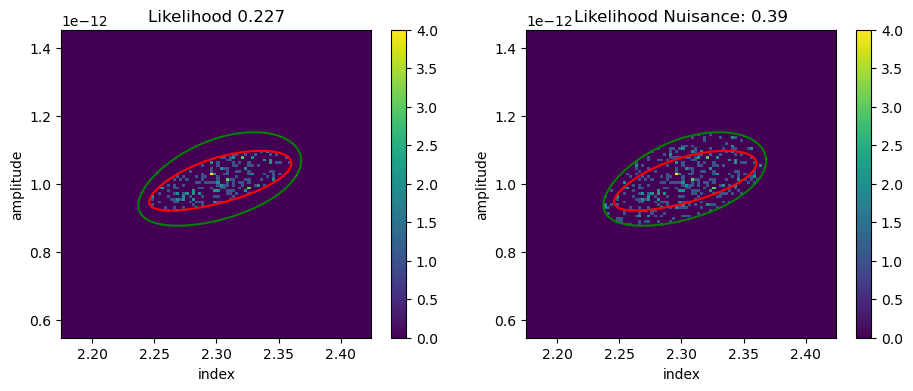

In [61]:
masked_N =  data_N_new * outside_N
masked =  data_N_new * outside

fig, (ax, ax2) = plt.subplots(1,2, figsize = (11,4))
im =ax.pcolormesh(indexy__new_N,
           amplix__new_N, masked)

fig.colorbar(im, ax=ax)
im =ax2.pcolormesh(indexy__new_N,
           amplix__new_N, masked_N)

fig.colorbar(im, ax=ax2)
for a in [ax, ax2]:
    a.set_ylabel("amplitude")
    a.set_xlabel("index",)
    a.plot(dat[:,0],dat[:,1], color = 'red')
    a.plot(dat_N[:,0],dat_N[:,1], color = 'green')

fraction_within_2d_N = np.sum(masked_N) /  np.sum(data_N_new)
fraction_within_2d = np.sum(masked) /  np.sum(data_N_new)

ax2.set_title(f"Likelihood Nuisance: {fraction_within_2d_N:.3}")
ax.set_title(f"Likelihood {fraction_within_2d:.3}")